# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles.

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Approche non supervisée](#section_2)

[3. Approche supervisée](#section_3)

[4. Approche supervisée avec Word Embedding : Word2Vec](#section_4)

[5. Approche supervisée avec Word Embedding : BERT](#section_5)

[6. Approche supervisée avec Sentence Embedding : USE](#section_6)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import ast
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
plt.rc('axes', titlesize=22) 
plt.rc('axes', labelsize=18) 
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [3]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
files = os.listdir(main_path+'saved_ressources/')
files

['bows.mm',
 'bows.mm.index',
 'bows1.mm',
 'bows1.mm.index',
 'bows2.mm',
 'bows2.mm.index',
 'data_cleaned.csv']

In [4]:
data = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned.csv', encoding='utf8')

In [5]:
data = data.applymap(lambda x: ast.literal_eval(x))

In [6]:
data.head()

,Tags,Texts
0,"[macos, emacs, scheme, interpreter, sicp]","[scheme, interpreter, interpreter, python, int..."
1,"[c#, functional-programming, delegates, lambda...","[scope, bug, compiler, voidfunction, delegate,..."
2,"[mysql, database, arrays, postgresql, stored-p...","[pass, array, procedure, pass, array, procedur..."
3,"[ios, objective-c, iphone, cocoa-touch, uibutton]","[state, buttonwithtype, figure, button, state,..."
4,"[database, nhibernate, exception-handling, con...","[check, application, column, constraint, colum..."


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159599 entries, 0 to 159598
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Tags    159599 non-null  object
 1   Texts   159599 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


Le jeu de données est trop important pour les temps de calculs à ma disposition.

J'ai deux possibilités : 
- prendre un sample de 5000 observations aléatoirement
- prendre les 5000 observations pour lesquelles la similarité entre les deux colonnes est importante

In [8]:
# data_sample = data.sample(2000)
# data_sample.reset_index(inplace=True, drop=True)
# print(data_sample.shape)
# data_sample.head()

In [9]:
from typing import List

In [10]:
def jaccard_similarity(list1: List[str], list2: List[str]) -> float:
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard_similarity = len(intersection) / len(union)
    return jaccard_similarity

def get_highest_similarity_rows(data: pd.DataFrame, col1: str, col2: str, n: int):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)


data_sample = get_highest_similarity_rows(data, "Tags", "Texts", 1000)
data_sample.drop(['jaccard_similarity'], axis=1, inplace=True)
data_sample.reset_index(inplace=True, drop=True)
print(data_sample.shape)
data_sample.head()

(1000, 2)


,Tags,Texts
0,"[javascript, jquery, string, date, object]","[jquery, javascript, convert, date, string, da..."
1,"[listview, javafx, tableview, scrollbar, hide]","[hide, scrollbar, listview, javafx, hide, scro..."
2,"[jpa, merge, entitymanager, persist, java-pers...","[jpa, entitymanager, merge, entitymanager, mer..."
3,"[python, django, image, gallery, portfolio]","[create, image, gallery, create, portfolio, dj..."
4,"[python, authentication, proxy, https, ntlm]","[python, https, proxy, ntlm, authentication, s..."


In [11]:
texts_list = data_sample["Texts"].to_list()
tags_list = data_sample["Tags"].to_list()

In [12]:
flat_texts = [" ".join(text) for text in texts_list]
flat_tags = [" ".join(tag) for tag in tags_list]

In [13]:
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

## <font color="#114b98" id="section_2">2. Approche non supervisée</font>

In [14]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.matutils import corpus2dense

LDA (Latent Dirichlet Allocation) est une technique de topic modeling qui permet de découvrir les thèmes cachés (ou "latents") dans un ensemble de textes. Elle permet de regrouper des textes qui traitent des mêmes sujets.

La classe LdaModel de gensim est basée sur l'algorithme d'allocation latente de Dirichlet (LDA), qui est un modèle probabiliste génératif utilisé pour découvrir les sujets cachés dans un corpus de textes. La classe LatentDirichletAllocation de scikit-learn est également basée sur l'algorithme LDA, mais elle peut avoir des différences en termes d'implémentation, comme l'algorithme d'optimisation utilisé ou les paramètres disponibles.

NMF (Non-negative Matrix Factorization) est une autre technique de topic modeling qui permet de décomposer une matrice document-terme en deux matrices de facteurs non-négatifs. Elle est souvent utilisée pour découvrir les thèmes cachés dans des textes.

La classe gensim Nmf est basée sur l'algorithme de factorisation de matrice non-négative, qui est différente de la classe NMF de scikit-learn, qui est basée sur la méthode de gradient projeté.

In [15]:
def determine_optimal_num_topics(data, vectorizer, n_topics_range, texts_list):
    """
    Given data, a vectorizer, a range of number of topics to test, and the list of texts,
    applies the models to the data and plots the silhouette and coherence scores to help 
    determine the optimal number of topics.
    
    """

    # Vectorize the data
    data = vectorizer.fit_transform(data)
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]

    # Initialize lists to store scores for LDA and NMF
    lda_scores = []
    nmf_scores = []
    coherence_nmf = []
    coherence_lda = []

    # Loop through the range of number of topics
    for n_topics in n_topics_range:
        
        # Calculate the silhouette score for the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, max_iter=300)
        lda.fit(data)
        topic_assignments = lda.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        lda_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))
        
        # Calculate the silhouette score for the NMF model
        nmf = NMF(n_components=n_topics, max_iter=300)
        nmf.fit(data)
        topic_assignments = nmf.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        nmf_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))
        
        # Calculate the coherence score for the LDA model
        lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary)
        cm_lda = CoherenceModel(model=lda, texts=texts_list, dictionary=dictionary, coherence='c_v')
        coherence_lda.append(cm_lda.get_coherence())
            
        # Calculate the coherence score for the NMF model
        nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary)
        cm_nmf = CoherenceModel(model=nmf, texts=texts_list, dictionary=dictionary, coherence='c_v')
        coherence_nmf.append(cm_nmf.get_coherence())
     
    scores = pd.DataFrame(columns=['topics_silhouette',
                                   'score_silhouette',
                                   'topics_coherence',
                                   'score_coherence'], 
                          index=['LDA', 'NMF'])

    scores['topics_silhouette'] = [n_topics_range[np.argmax(lda_scores)], n_topics_range[np.argmax(nmf_scores)]]
    scores['score_silhouette'] = [max(lda_scores), max(nmf_scores)]
    scores['topics_coherence'] = [n_topics_range[np.argmax(coherence_lda)], n_topics_range[np.argmax(coherence_nmf)]]
    scores['score_coherence'] = [max(coherence_lda), max(coherence_nmf)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    plt.suptitle('Silhouette and Coherence Scores for LDA and NMF with {}'.format(str(vectorizer).split('(')[0]))
    
    ax1.plot(n_topics_range, lda_scores, label='LDA')
    ax1.plot(n_topics_range, nmf_scores, label='NMF')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Silhouette score')
    ax1.legend()

    ax2.plot(n_topics_range, coherence_lda, label='LDA')
    ax2.plot(n_topics_range, coherence_nmf, label='NMF')
    ax2.set_xlabel('Number of Topics')
    ax2.set_ylabel('Coherence score')
    ax2.legend()

    plt.show()
    
    return scores

In [16]:
# Define the range of number of topics to test
n_topics_range = range(2, 40, 4)

CountVectorizer() est une implémentation de l'approche bag-of-words pour la vectorisation de textes. Il convertit un ensemble de documents en un tableau de compte de mots (ou un sac de mots), où chaque ligne représente un document et chaque colonne représente un mot. Le nombre dans chaque cellule est le nombre de fois où le mot correspondant est présent dans le document correspondant.

In [17]:
# Initialize the vectorizer
vectorizer = CountVectorizer()

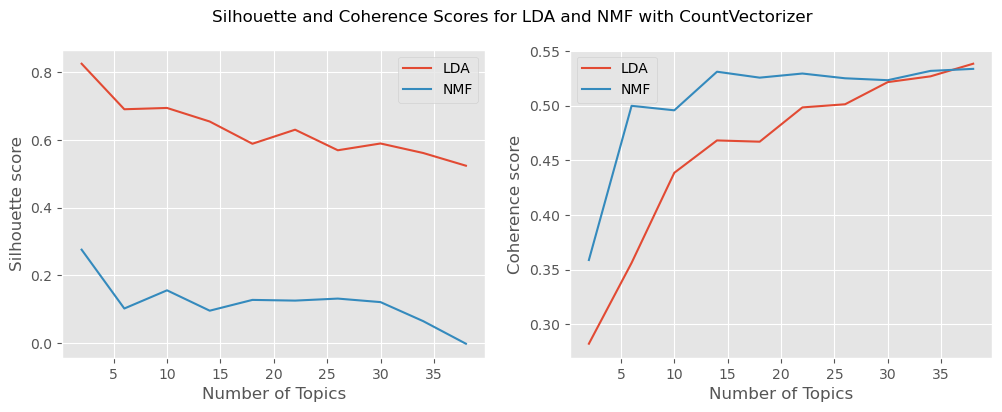

In [18]:
nmf_and_lda_models_with_CountVectorizer = determine_optimal_num_topics(flat_texts, vectorizer, n_topics_range, texts_list)

In [19]:
nmf_and_lda_models_with_CountVectorizer

,topics_silhouette,score_silhouette,topics_coherence,score_coherence
LDA,2,0.825642,38,0.538217
NMF,2,0.275823,38,0.533520


TF-IDF (term frequency-inverse document frequency) est une technique utilisée pour pondérer les termes dans les textes en fonction de leur fréquence d'apparition. Elle permet de donner plus de poids aux termes qui apparaissent fréquemment dans un document mais rarement dans l'ensemble des documents.

In [20]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts)

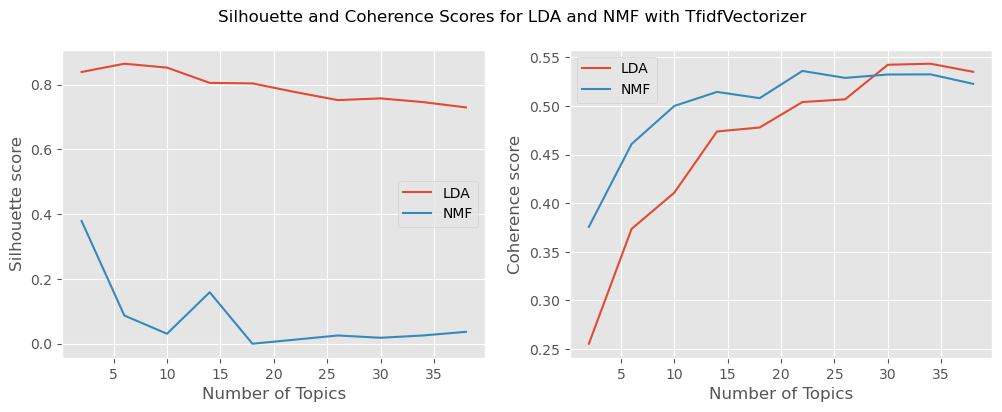

In [21]:
nmf_and_lda_models_with_TfidfVectorizer= determine_optimal_num_topics(flat_texts, vectorizer, n_topics_range, texts_list)

In [22]:
nmf_and_lda_models_with_TfidfVectorizer

,topics_silhouette,score_silhouette,topics_coherence,score_coherence
LDA,6,0.864459,34,0.543469
NMF,2,0.378849,22,0.536026


Le score de silhouette mesure la similarité d'un objet à son propre groupe par rapport aux autres groupes et généralement, plus il est proche de 1, meilleure est la classification. Le score de cohérence mesure à quel point les sujets sont "interprétables par les humains", généralement plus proche de 1, meilleur c'est.

Dans notre situation, lorsque le nombre de sujets augmente, ils sont plus "interprétables par les humains".

Nous devons maintenant essayer d'obtenir des tags en utilisant ces méthodes.

Je choisis d'utiliser uniquement LDA pour la suite car c'est la méthode qui obtient les meilleurs scores.

Le paramètre min_df définit le nombre minimum de documents dans lesquels un mot doit être présent pour être inclus dans le vocabulaire.

In [23]:
min_df=25

Le paramètre max_df définit la fréquence maximale d'un mot en pourcentage de tous les documents. 

In [24]:
max_df=0.5

Je choisis le nombre de topics au regard des résultats précédents.

In [25]:
n_topics = 11

In [26]:
def get_tags_from_text(texts_list, flat_texts, n_topics, vocabulary_texts, min_df, max_df):
    
    # Predict tags using LdaModel (gensim) without bow or TF-IDF 
    pred_tags_gensim = list()
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]
    lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=42)
    for text in texts_list:
        bow = dictionary.doc2bow(text)
        topics = lda.get_document_topics(bow, minimum_probability=0)
        topic_id, prob = max(topics, key=lambda x: x[1])
        topic_words = [w for w, p in lda.show_topic(topic_id, topn=5)]
        pred_tags_gensim.append(topic_words)

    # Predict tags using LDA (sklearn) without bow or TF-IDF  
    pred_tags_sklearn = list()
    corpus_dense = corpus2dense(corpus, num_terms=len(dictionary)).T
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(corpus_dense)
    for text in texts_list:
        bow = dictionary.doc2bow(text)
        dense_bow = corpus2dense([bow], num_terms=len(dictionary)).T[0]
        dense_bow = np.reshape(dense_bow, (1, -1))
        topic_distribution = lda.transform(dense_bow)
        topic_id = topic_distribution.argmax()
        top_words_indices = np.argsort(-lda.components_[topic_id])[:5]
        topic_words = [dictionary[i] for i in top_words_indices]
        pred_tags_sklearn.append(topic_words)     
        
    # Predict tags using LdaModel with TF-IDF 
    pred_tags_tfidf = list()
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, vocabulary=vocabulary_texts)
    bow_matrix = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(bow_matrix)
    for text in texts_list:
        bow = vectorizer.transform(text)
        topics = lda.transform(bow)
        topic_id = topics.argmax(axis=1)[0]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[:, topic_id].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_tags_tfidf.append(topic_words)
        
    # Predict tags using LdaModel with CountVectorizer 
    pred_tags_count = list()
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, vocabulary=vocabulary_texts)
    bow_matrix = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(bow_matrix)
    for text in texts_list:
        bow = vectorizer.transform(text)
        topics = lda.transform(bow)
        topic_id = topics.argmax(axis=1)[0]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[:, topic_id].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_tags_count.append(topic_words)    
        
    return pred_tags_gensim, pred_tags_sklearn, pred_tags_tfidf, pred_tags_count

In [27]:
pred_tags_gensim, pred_tags_sklearn, pred_tags_tfidf, pred_tags_count = get_tags_from_text(texts_list,
                                                                                           flat_texts,
                                                                                           n_topics,
                                                                                           vocabulary_texts,
                                                                                           min_df,
                                                                                           max_df)

In [28]:
tags_list[0:5]

[['javascript', 'jquery', 'string', 'date', 'object'],
 ['listview', 'javafx', 'tableview', 'scrollbar', 'hide'],
 ['jpa', 'merge', 'entitymanager', 'persist', 'java-persistence-api'],
 ['python', 'django', 'image', 'gallery', 'portfolio'],
 ['python', 'authentication', 'proxy', 'https', 'ntlm']]

In [29]:
pred_tags_gensim[0:5]

[['javascript', 'function', 'date', 'python', 'way'],
 ['database', 'java', 'python', 'selenium', 'mongodb'],
 ['javascript', 'java', 'image', 'project', 'difference'],
 ['use', 'function', 'project', 'file', 'python'],
 ['list', 'use', 'function', 'jquery', 'class']]

In [30]:
pred_tags_sklearn[0:5]

[['python', 'date', 'function', 'way', 'class'],
 ['database', 'selenium', 'java', 'python', 'use'],
 ['javascript', 'css', 'html', 'java', 'image'],
 ['use', 'merge', 'ruby', 'eclipse', 'commit'],
 ['file', 'java', 'project', 'image', 'jquery']]

In [31]:
pred_tags_tfidf[0:5]

[['sha', 'cst', 'code', 'sqoop', 'boxplot'],
 ['boxplot', 'infinity', 'apple', 'case', 'isr'],
 ['infinity', 'apple', 'case', 'isr', 'bcrypt'],
 ['code', 'sqoop', 'boxplot', 'infinity', 'apple'],
 ['laurent', 'checkout', 'identity', 'sha', 'cst']]

In [32]:
pred_tags_count[0:5]

[['sha', 'cst', 'code', 'sqoop', 'boxplot'],
 ['boxplot', 'infinity', 'apple', 'case', 'isr'],
 ['infinity', 'apple', 'case', 'isr', 'bcrypt'],
 ['code', 'sqoop', 'boxplot', 'infinity', 'apple'],
 ['laurent', 'checkout', 'identity', 'sha', 'cst']]

Il semble que CountVectorizer et TfidfVectorizer prédisent les mêmes tags.

## <font color="#114b98" id="section_3">3. Approche supervisée</font>

In [207]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, jaccard_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [208]:
mlb = MultiLabelBinarizer(classes=vocabulary_tags)

In [209]:
tags_mlb = mlb.fit_transform(flat_tags)

In [36]:
classifiers = [LogisticRegression(random_state=42, max_iter=300, tol=1e-5),
               SGDClassifier(random_state=42, max_iter=300, tol=1e-5),
               RandomForestClassifier(random_state=42),
               KNeighborsClassifier(),
               MultinomialNB()]

 - Accuracy: mesure de combien de prédictions faites par le modèle sont correctes
 - Precision: mesure combien des prédictions positives faites par le modèle sont effectivement correctes. Un score de précision élevé signifie que le modèle fait peu de prédictions positives fausses.
 - Recall: mesure combien des exemples positifs réels sont correctement prédits par le modèle. Un score de rappel élevé signifie que le modèle est capable de trouver la plupart des exemples positifs.
 - F1 Score: mesure de l'exactitude d'un modèle, il est un moyen harmonique de précision et de rappel. Il varie de 0 à 1, où un score proche de 1 indique une meilleure performance et un score proche de 0 indique une performance moins bonne. 
 - Jaccard Score: mesure de la similarité entre les deux ensembles de prédictions et de vraies étiquettes. Il varie de 0 à 1, où un score proche de 1 indique une très grande similitude et un score proche de 0 indique une grande dissimilarité.

In [37]:
def calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifiers):
    
    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall',
                                       'F1 Score', 'Jaccard Score', 'Time (s)'])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)
    
    # Vectorize X_train and X_test
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    # Fit an independent model for each class using the OneVsRestClassifier wrapper.
    for classifier in classifiers:
        start_time = time.time()
        ovrc = OneVsRestClassifier(classifier)
        ovrc.fit(X_train, y_train)
        y_pred_ovrc = ovrc.predict(X_test)
        end_time = time.time()
        
        accuracy = round(accuracy_score(y_test, y_pred_ovrc), 4)
        precision = round(precision_score(y_test, y_pred_ovrc, average='samples'), 4)
        recall = round(recall_score(y_test, y_pred_ovrc, average='samples'), 4)
        f1 = round(f1_score(y_test, y_pred_ovrc, average='samples'), 4)
        jaccard = round(jaccard_score(y_test, y_pred_ovrc, average='samples'), 4)
        time_taken = round(end_time - start_time, 4)
        
        results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                       'Accuracy': accuracy, 
                                       'Precision': precision, 
                                       'Recall': recall, 
                                       'F1 Score': f1, 
                                       'Jaccard Score': jaccard,
                                       'Time (s)': time_taken}, 
                                       ignore_index=True)
                                       
        print('Results for classifier:', classifier)
        print("Accuracy : ", accuracy)
        print("Precision : ", precision)
        print("Recall : ", recall)
        print("F1 Score : ", f1)
        print("Jaccard Score:", jaccard)
        print("Time (s):", time_taken)
        print('\n')
        
    return results_df

In [38]:
# Initialize the vectorizer
vectorizer = CountVectorizer()

In [39]:
results_df_CountVectorizer = calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifiers)

Results for classifier: LogisticRegression(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.63
Precision :  0.835
Recall :  0.8725
F1 Score :  0.8283
Jaccard Score: 0.7775
Time (s): 0.2732


Results for classifier: SGDClassifier(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.575
Precision :  0.815
Recall :  0.8275
F1 Score :  0.7933
Jaccard Score: 0.7375
Time (s): 0.2692


Results for classifier: RandomForestClassifier(random_state=42)
Accuracy :  0.685
Precision :  0.8275
Recall :  0.9475
F1 Score :  0.865
Jaccard Score: 0.82
Time (s): 0.8968


Results for classifier: KNeighborsClassifier()
Accuracy :  0.665
Precision :  0.8225
Recall :  0.9425
F1 Score :  0.8583
Jaccard Score: 0.81
Time (s): 0.2652


Results for classifier: MultinomialNB()
Accuracy :  0.65
Precision :  0.8325
Recall :  0.88
F1 Score :  0.8333
Jaccard Score: 0.7875
Time (s): 0.2582




In [40]:
results_df_CountVectorizer

,Classifier,Accuracy,Precision,Recall,F1 Score,Jaccard Score,Time (s)
0,LogisticRegression,0.630,0.8350,0.8725,0.8283,0.7775,0.2732
1,SGDClassifier,0.575,0.8150,0.8275,0.7933,0.7375,0.2692
2,RandomForestClassifier,0.685,0.8275,0.9475,0.8650,0.8200,0.8968
3,KNeighborsClassifier,0.665,0.8225,0.9425,0.8583,0.8100,0.2652
4,MultinomialNB,0.650,0.8325,0.8800,0.8333,0.7875,0.2582


Selon ces résultats, il semble que le RandomForestClassifier a les meilleures performances globales, avec la plus grande précision, rappel et score F1. Le classificateur de régression logistique se comporte également bien, avec une précision légèrement inférieure.

Cependant, le RandomForestClassifier est aussi le seul à nécessiter un temps d'entraînement aussi long.

In [41]:
def plot_results(results_df):
    
    # Create a figure with 5 subplots
    fig, axs = plt.subplots(2, 3, figsize=(20,10))
    # Set a color palette
    my_palette = sns.color_palette("husl", 5)
    
    # Set the x-axis to be a range of numerical values
    x = range(len(results_df))
    scoring_methods = ['Accuracy','Precision','Recall','F1 Score','Jaccard Score', 'Time (s)']
    
    # Create a bar plot for each subplot
    sns.barplot(x='Classifier', y='Accuracy', data=results_df, ax=axs[0,0], palette=my_palette, label='Accuracy')
    sns.barplot(x='Classifier', y='Precision', data=results_df, ax=axs[0,1], palette=my_palette, label='Precision')
    sns.barplot(x='Classifier', y='Recall', data=results_df, ax=axs[0,2], palette=my_palette, label='Recall')
    sns.barplot(x='Classifier', y='F1 Score', data=results_df, ax=axs[1,0], palette=my_palette, label='F1 Score')
    sns.barplot(x='Classifier', y='Jaccard Score', data=results_df, ax=axs[1,1], palette=my_palette, label='Jaccard Score')
    sns.barplot(x='Classifier', y='Time (s)', data=results_df, ax=axs[1,2], palette=my_palette, label='Time (s)')
    
    # Add classifier names to x-axis
    for i in range(2):
        for j in range(3):
            axs[i,j].set_title(scoring_methods[i*3+j])
            axs[i,j].set_xticks(x)
            axs[i,j].set_xlabel('')
            
            if j == 0:
                axs[i,j].set_ylabel('Score')
            else:
                axs[i,j].set_ylabel('')
            
            if i == 1:
                axs[i,j].set_xticklabels(results_df['Classifier'], rotation=90)
            else:
                axs[i,j].set_xticklabels('')
            

    
    plt.show()

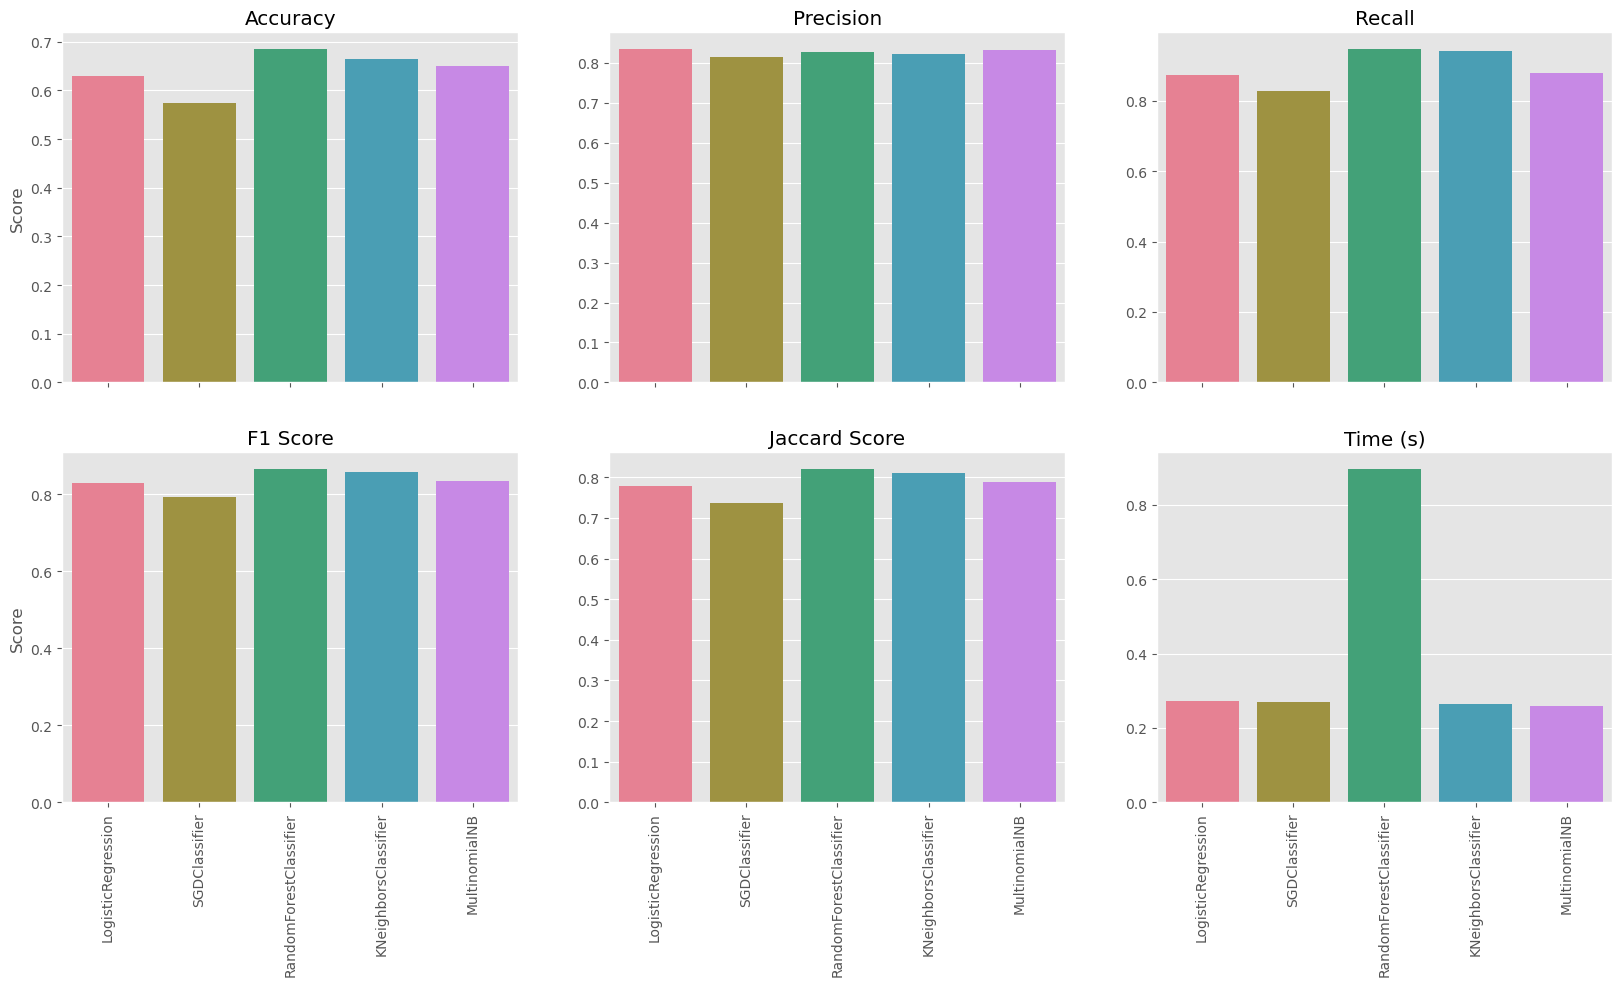

In [42]:
# Call the plot_results function
plot_results(results_df_CountVectorizer)

In [43]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts)

In [44]:
results_df_TfidfVectorizer = calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifiers)

Results for classifier: LogisticRegression(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.68
Precision :  0.8225
Recall :  0.95
F1 Score :  0.8633
Jaccard Score: 0.8175
Time (s): 0.2682


Results for classifier: SGDClassifier(max_iter=300, random_state=42, tol=1e-05)
Accuracy :  0.555
Precision :  0.8125
Recall :  0.795
F1 Score :  0.775
Jaccard Score: 0.7175
Time (s): 0.2612


Results for classifier: RandomForestClassifier(random_state=42)
Accuracy :  0.685
Precision :  0.8275
Recall :  0.9475
F1 Score :  0.865
Jaccard Score: 0.82
Time (s): 1.2772


Results for classifier: KNeighborsClassifier()
Accuracy :  0.665
Precision :  0.8225
Recall :  0.9175
F1 Score :  0.8467
Jaccard Score: 0.8
Time (s): 0.3853


Results for classifier: MultinomialNB()
Accuracy :  0.685
Precision :  0.8225
Recall :  0.96
F1 Score :  0.8683
Jaccard Score: 0.8225
Time (s): 0.2652




In [45]:
results_df_TfidfVectorizer

,Classifier,Accuracy,Precision,Recall,F1 Score,Jaccard Score,Time (s)
0,LogisticRegression,0.680,0.8225,0.9500,0.8633,0.8175,0.2682
1,SGDClassifier,0.555,0.8125,0.7950,0.7750,0.7175,0.2612
2,RandomForestClassifier,0.685,0.8275,0.9475,0.8650,0.8200,1.2772
3,KNeighborsClassifier,0.665,0.8225,0.9175,0.8467,0.8000,0.3853
4,MultinomialNB,0.685,0.8225,0.9600,0.8683,0.8225,0.2652


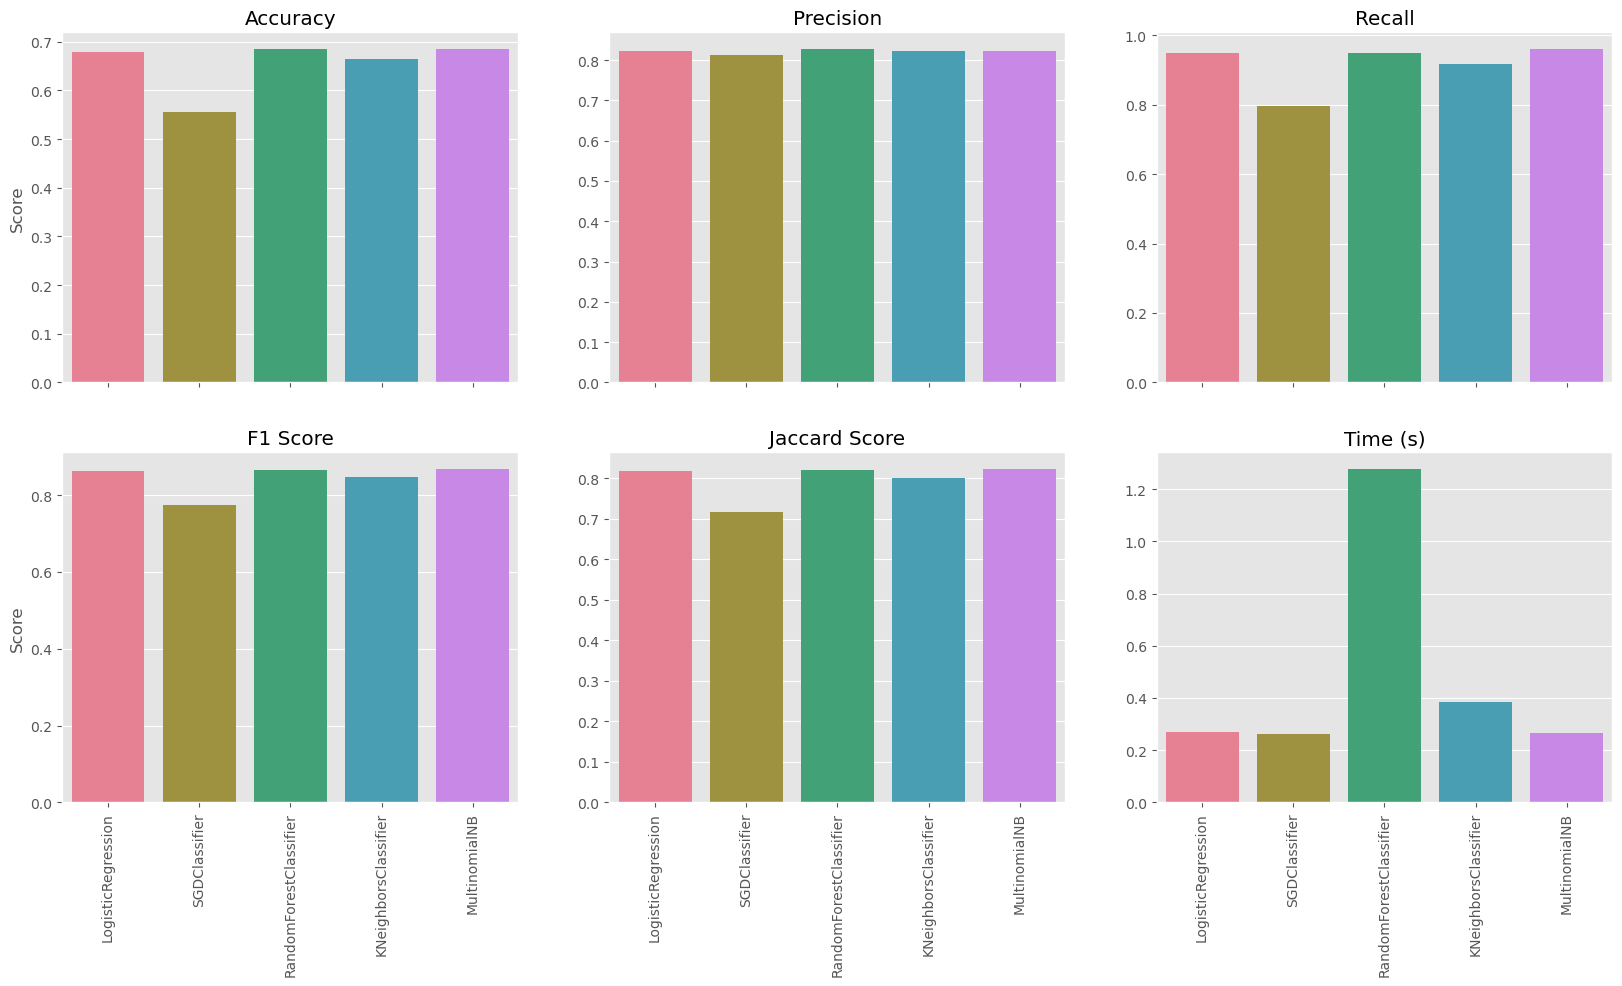

In [46]:
# Call the plot_results function
plot_results(results_df_TfidfVectorizer)

Le RandomForestClassifier obtient les meilleurs scores, peu importe le vectorizer utilisé.

In [47]:
results_RFC = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Jaccard Score'])
results_RFC = results_RFC.append(results_df_CountVectorizer.iloc[2,1:]).reset_index(drop=True)
results_RFC = results_RFC.append(results_df_TfidfVectorizer.iloc[2,1:]).reset_index(drop=True)
results_RFC['Classifier'] = ['CountVectorizer', 'TfidfVectorizer']
# results_RFC = results_RFC.set_index([['CountVectorizer', 'TfidfVectorizer']])
results_RFC

,Accuracy,Precision,Recall,F1 Score,Jaccard Score,Time (s),Classifier
0,0.685,0.8275,0.9475,0.865,0.82,0.8968,CountVectorizer
1,0.685,0.8275,0.9475,0.865,0.82,1.2772,TfidfVectorizer


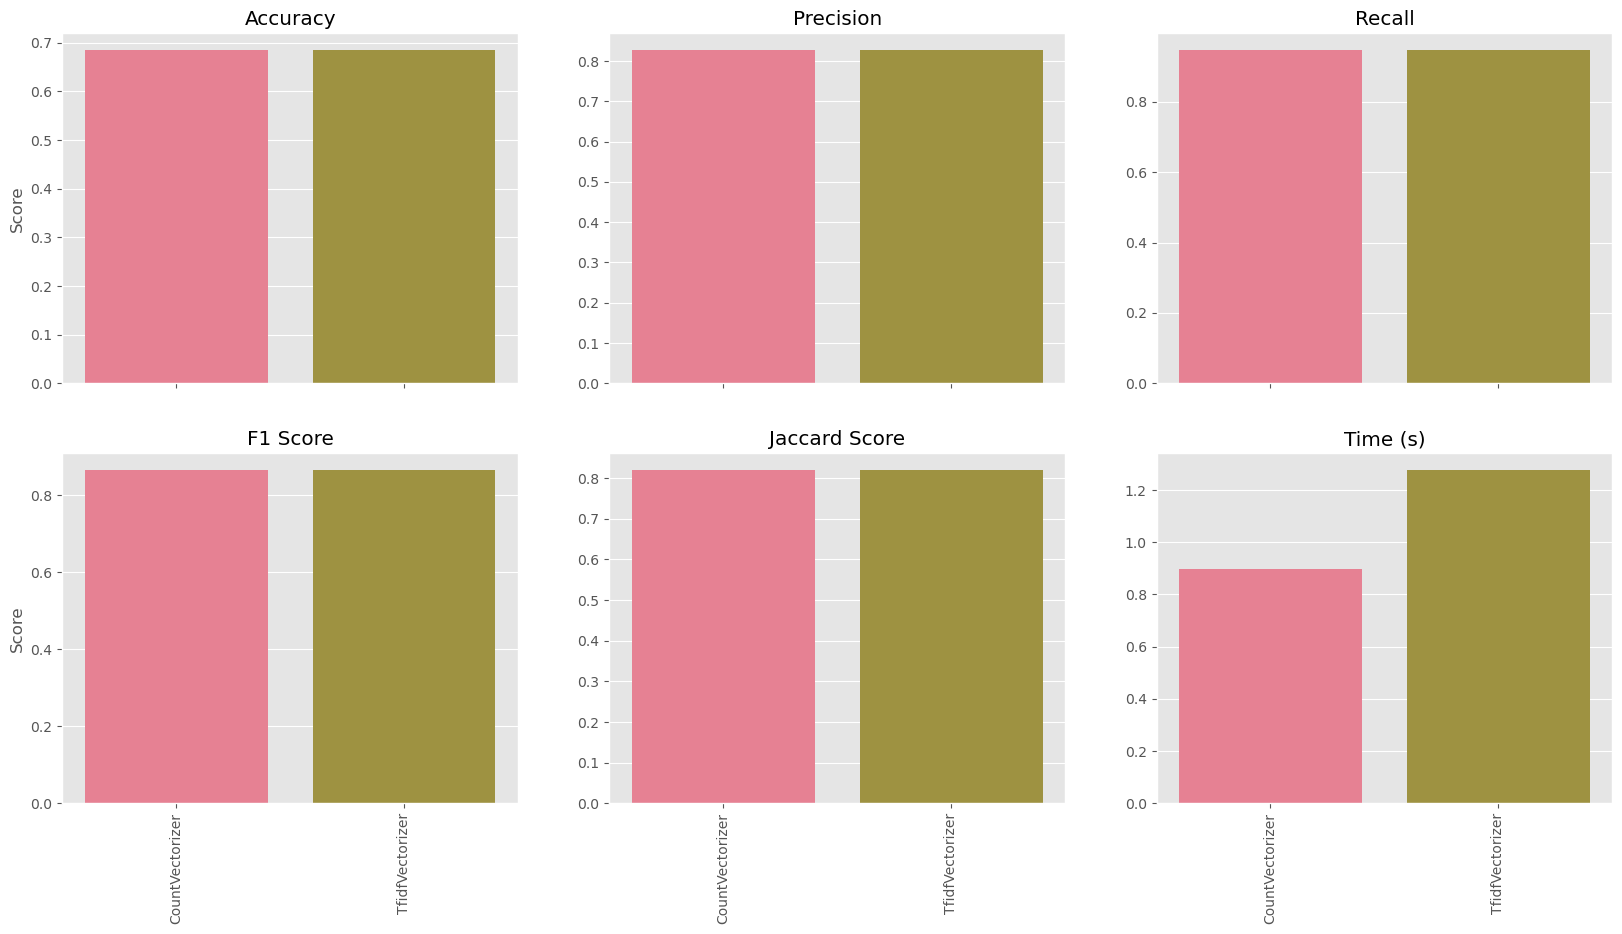

In [48]:
# Call the plot_results function
plot_results(results_RFC)

CountVectorizer permet d'avoir des performances similaires avec un temps d'entraînement plus court que TfidfVectorizer.

## <font color="#114b98" id="section_4">4. Approche supervisée avec Word Embedding : Word2Vec</font>

In [235]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer

In [252]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts_list, tags_list, test_size=0.2, random_state=42)

In [253]:
# Train the Word2Vec model on your text data
w2v_model = Word2Vec(X_train, vector_size=1000, window=5, min_count=5, workers=4)

In [254]:
# Create a vocabulary of only the words in the text data that are in the word2vec model
vocab = set(w2v_model.wv.key_to_index.keys())

In [255]:
# Filter the text data to only include words in the vocabulary
X_train = [[word for word in sublist if word in vocab] for sublist in X_train]
X_test = [[word for word in sublist if word in vocab] for sublist in X_test]

In [256]:
# Remove any observations that have no words in the vocabulary
train_removed_indexes = []
test_removed_indexes = []
for i, sublist in enumerate(X_train):
    if not any(word in vocab for word in sublist):
        train_removed_indexes.append(i)
for i, sublist in enumerate(X_test):
    if not any(word in vocab for word in sublist):
        test_removed_indexes.append(i)

In [257]:
X_train = [x for i, x in enumerate(X_train) if i not in train_removed_indexes]
X_test = [x for i, x in enumerate(X_test) if i not in test_removed_indexes]
y_train = [x for i, x in enumerate(y_train) if i not in train_removed_indexes]
y_test = [x for i, x in enumerate(y_test) if i not in test_removed_indexes]

In [258]:
# Create embeddings for train and test data
X_train_embedded = [np.mean([w2v_model.wv[word] for word in sentence], axis=0) for sentence in X_train]
X_test_embedded = [np.mean([w2v_model.wv[word] for word in sentence], axis=0) for sentence in X_test]

In [262]:
label_binarizer = LabelBinarizer()
y_train_binary = label_binarizer.fit_transform(y_train)

ValueError: Multioutput target data is not supported with label binarization

In [259]:
# y_train_mlb = mlb.fit_transform(y_train)

In [260]:
# Create the multi-label classifier
clf = OneVsRestClassifier(LogisticRegression(random_state=42))

In [261]:
# Fit the classifier on the train data
# clf.fit(X_train_embedded, y_train_mlb)
clf.fit(X_train_embedded, y_train)

ValueError: Multioutput target data is not supported with label binarization

In [224]:
# Make predictions on the test data
y_pred_mlb = clf.predict(X_test_embedded)

In [230]:
# Convert the predictions and true labels into binary format (needed for the evaluation metrics)
y_test_mlb = mlb.transform(y_test)

In [231]:
# Calculate precision, recall, and f1-score
precision = precision_score(y_test_mlb, y_pred_mlb, average='micro')
recall = recall_score(y_test_mlb, y_pred_mlb, average='micro')
f1 = f1_score(y_test_mlb, y_pred_mlb, average='micro')

In [232]:
# Print the results
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

Precision: 0.00
Recall: 0.00
F1-Score: 0.00


In [ ]:
My code is the following :

mlb = MultiLabelBinarizer(classes=vocabulary_tags)
tags_mlb = mlb.fit_transform(flat_tags)

# Train the Word2Vec model on your text data
w2v_model = Word2Vec(texts_list, vector_size=1000, window=5, min_count=5, workers=4)

# Create a vocabulary of only the words in the text data that are in the word2vec model
vocab = set(w2v_model.wv.key_to_index.keys())

# Filter the text data to only include words in the vocabulary
filtered_texts_list = [[word for word in sublist if word in vocab] for sublist in texts_list]

# Remove any observations that have no words in the vocabulary
removed_indexes = []
for i, sublist in enumerate(texts_list):
    if not any(word in vocab for word in sublist):
        removed_indexes.append(i)
y = [label for i, label in enumerate(tags_mlb) if i not in removed_indexes]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

where : 
 - texts_list : [['jquery',
  'javascript',
  'convert',
  'date',
  'string',
  'date',
  'date',
  'string',
  'convert',
  'date',
  'object'],
 ['hide', 'scrollbar', 'listview', 'javafx', 'hide', 'scrollbar', 'listview'],
 ['jpa', 'entitymanager', 'merge', 'entitymanager', 'merge', 'persist'],
 ['create',
  'image',
  'gallery',
  'create',
  'portfolio',
  'django',
  'python',
  'django',
  'model'],
 ['python',
  'https',
  'proxy',
  'ntlm',
  'authentication',
  'support',
  'https',
  'authentication',
  'authentication',
  'https',
  'proxy',
  'ntlm',
  'authentication',
  'laurent'],
                 
 - vocab :    {'access',
 'activity',
 'address',
 'advance',
 'agent',
 'ajax',
 'algorithm',
 'anaconda',
 'android',
 'animation
               
 - flat_tags : ['javascript jquery string date object',
 'listview javafx tableview scrollbar hide',
 'jpa merge entitymanager persist java-persistence-api',
 'python django image gallery portfolio',
 'python authentication proxy https ntlm',
 'apache import export repository jackrabbit',
 'java eclipse jar project refresh',
 'java concurrency future executorservice callable',
                
 - vocabulary_tags : ['jakarta-ee',
 'packet',
 'bcrypt',
 'machine-learning',
 'sublimetext3',
 'isr',
 'case',
 'mysql-workbench',
 'infinity',

In [170]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

In [171]:
# Train the Word2Vec model on your text data
w2v_model = Word2Vec(texts_list, vector_size=1000, window=5, min_count=5, workers=4)

In [172]:
# Create a vocabulary of only the words in the text data that are in the word2vec model
vocab = set(w2v_model.wv.key_to_index.keys())

In [173]:
# Filter the text data to only include words in the vocabulary
filtered_texts_list = [[word for word in sublist if word in vocab] for sublist in texts_list]

In [174]:
# Remove any observations that have no words in the vocabulary
removed_indexes = []
for i, sublist in enumerate(texts_list):
    if not any(word in vocab for word in sublist):
        removed_indexes.append(i)
y = [label for i, label in enumerate(tags_mlb) if i not in removed_indexes]

In [175]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
X_train

KeyboardInterrupt: 

## <font color="#114b98" id="section_5">5. Approche supervisée avec Word Embedding : BERT</font>

In [ ]:
# !pip install transformers

In [ ]:
# !pip install --user TensorFlow

In [ ]:
# !pip install torch

In [ ]:
# conda install pytorch torchvision torchaudio cpuonly -c pytorch

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
import torch
import torchvision

In [ ]:
# Load the BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# Encode the text data as input for the BERT model
input_ids = []
attention_masks = []
for text in flat_texts:
    encoded_text = tokenizer.encode_plus(text, add_special_tokens=True, max_length=512, pad_to_max_length=True)
    input_ids.append(encoded_text["input_ids"])
    attention_masks.append(encoded_text["attention_mask"])

In [ ]:
# Convert the lists to PyTorch tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(flat_tags)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2)

In [ ]:
# Create a DataLoader for the training set
train_dataloader = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)

In [ ]:
# Create an optimizer and scheduler for fine-tuning the BERT model
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 5)

In [ ]:
# Fine-tune the BERT model on the training data
for epoch in range(5):
    model.train()
    for step, batch in enumerate(train_dataloader):
        input_ids, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks)
        loss = criterion(outputs[0], labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
# Make predictions on the test data
model.eval()
with torch.no_grad():
    test_logits = model(X_test, attention_mask=attention_masks)

In [ ]:
# Convert the logits to predictions
test_preds = torch.argmax(test_logits, axis=1)

In [ ]:
# Evaluate the model's accuracy on the test data
print(accuracy_score(y_test, test_preds))

## <font color="#114b98" id="section_6">6. Approche supervisée avec Sentence Embedding : USE</font>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow_hub

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

In [ ]:
# Load the USE model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# Encode the text data as input for the USE model
X = use_model(flat_texts).numpy()

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, flat_tags, test_size=0.2)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Train a classifier on the encoded text data
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(flat_tags)), activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
# Evaluate the model's accuracy on the test data
print(accuracy_score(y_test, y_pred))